# Predictive Team Outcomes - Regression Analyses

Goal: See which features are most predictive of team outcomes (`num_teams`, `num_funded_teams`).

These outcomes are the numbers of teams formed from these sessions and number of those teams whose proposals are actually funded.

Background info: For more on how the features are calculated, code is in `calculate_features.py` (published to Evey's git).

In [2]:
import pandas as pd

# Load the dataset from the correct relative path
df = pd.read_excel("../Data/all_data_df.xlsx")

# Confirm it loaded
print(df.shape)
df.head()


(83, 45)


,conference,session,num_present_new_idea,num_provide_supporting_evidence,num_propose_decision,num_expand_on_existing_idea,num_express_agreement,num_explain_define_term,num_reject_idea,num_acknowledge_contribution,...,decision_lag,idea_agree_decision_chain_duration,burstiness_of_ideas,conflict_resolution_latency,screenshare_count,screenshare_duration,avg_screenshare_segment_length,screenshare_decision_overlap,num_teams,num_funded_teams
0,2021ABI,2021_05_20_ABI_S5,12,23.0,9,42.0,28,25.0,3,23,...,291.090909,NaN,1.154701,NaN,1.0,258.0,258.000000,0.058824,3,0
1,2021ABI,2021_05_20_ABI_S4,12,6.0,5,17.0,17,30.0,0,23,...,835.583333,NaN,0.816497,NaN,7.0,278.0,39.714286,0.000000,2,2
2,2021ABI,2021_05_21_ABI_S16,11,10.0,8,23.0,17,18.0,0,30,...,247.500000,NaN,0.785674,NaN,2.0,777.0,388.500000,0.035714,0,0
3,2021ABI,2021_05_21_ABI_S1,17,8.0,14,37.0,32,24.0,0,18,...,220.647059,NaN,1.552417,NaN,7.0,252.0,36.000000,0.080000,2,2
4,2021ABI,2021_05_20_ABI_S8,8,22.0,8,43.0,45,24.0,1,44,...,376.000000,NaN,1.053269,NaN,8.0,257.0,32.125000,0.086957,4,0


# Importing  & Setup

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_excel("../Data/all_data_df.xlsx")
df = df.dropna(subset=["num_teams", "num_funded_teams"])  # Clean target rows



# Setting Up Predictors & Targets

In [6]:
excluded = ["conference", "session", "num_teams", "num_funded_teams"]
predictors = [col for col in df.columns if col not in excluded]

# Optional: binary version for logistic
df["has_funded_team"] = (df["num_funded_teams"] > 0).astype(int)


# Checking for Overdispersion

In [7]:
mean_funded = df["num_funded_teams"].mean()
var_funded = df["num_funded_teams"].var()
print(f"Mean: {mean_funded:.2f}, Variance: {var_funded:.2f}")

# note: if variance >> mean, try negative binomial later

Mean: 0.59, Variance: 0.90


With variance slightly higher than mean, only a mild level of overdispersion - using Poisson Regression wouldn't undermine interpretability

# Poisson Regression - Number of Teams Formed

We use Poisson regression because our outcomes are counts, and it models non-negative, skewed data better than linear regression, as long as the variance isn’t much larger than the mean.

## Poisson Regression: num_teams

In [22]:
## Poisson Regression: num_teams

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Step 1: Clean outcome rows
df = df.dropna(subset=["num_teams", "num_funded_teams"])

# Step 2: Define candidate predictors
excluded = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors = [col for col in df.columns if col not in excluded]

# Step 3: Filter predictors (numeric, not all-null, not constant)
predictors = [
    col for col in candidate_predictors
    if pd.api.types.is_numeric_dtype(df[col])
    and not df[col].isnull().all()
    and df[col].nunique() > 1
]

# Step 4: Drop sparse predictors (< 5 non-zero entries)
predictors = [col for col in predictors if (df[col].fillna(0) != 0).sum() >= 5]

print(f"Number of predictors: {len(predictors)}")
print("Predictors:", predictors)

# Step 5: Impute missing values
df_model = df.copy()
df_model[predictors] = df_model[predictors].fillna(0)

# Step 6: Fit initial Poisson regression
formula_teams = "num_teams ~ " + " + ".join(predictors)
warnings.simplefilter("ignore", ConvergenceWarning)
model_initial = smf.poisson(formula=formula_teams, data=df_model).fit(maxiter=100, disp=0)

# Step 7: Identify bad predictors from model object directly
params = model_initial.params
std_errs = model_initial.bse
bad_preds = [var for var in params.index if var != "Intercept" and (
    pd.isna(std_errs[var]) or abs(params[var]) > 1e3
)]

print("\nRemoved problematic predictors:", bad_preds)

# Step 8: Drop and refit if needed
predictors_clean = [p for p in predictors if p in formula_teams and p not in bad_preds]
print(f"Refitting model with {len(predictors_clean)} predictors.")

final_formula = "num_teams ~ " + " + ".join(predictors_clean)
poisson_teams_final = smf.poisson(formula=final_formula, data=df_model).fit(maxiter=100, disp=0)

# Step 9: Show final summary
print(poisson_teams_final.summary())


Number of predictors: 40
Predictors: ['num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_distraction_per_utterance', 'gesture_count_ratio', 'num_overlaps', 'ideas_first_half', 'ideas_second_half', 'decision_lag', 'idea_agree_decision_chain_duration', 'burstiness_of_ideas', 'conflict_resolution_latency', 'screen

## Testing for Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
import pandas as pd

# Step 1: Add constant for intercept
X_vif = add_constant(df_model[predictors_clean])

# Step 2: Compute VIF
vif_data = pd.DataFrame({
    "predictor": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Step 3: Drop intercept and sort
vif_data = vif_data[vif_data["predictor"] != "const"].sort_values(by="VIF", ascending=False)
print("=== VIF Table ===")
print(vif_data.to_string(index=False))

# Step 4: Drop predictors with VIF = inf (or VIF > 10 if you want to be stricter)
vif_filtered = vif_data[vif_data["VIF"] < 10]
predictors_vif = vif_filtered["predictor"].tolist()

print(f"\nRemoved {len(predictors_clean) - len(predictors_vif)} predictors due to high VIF.")

# Step 5: Refit Poisson model
formula_vif = "num_teams ~ " + " + ".join(predictors_vif)
poisson_vif_model = smf.poisson(formula=formula_vif, data=df_model).fit()
print("\n=== Final Poisson Model (after VIF filtering) ===")
print(poisson_vif_model.summary())


=== VIF Table ===
                         predictor       VIF
              num_present_new_idea       inf
                   num_assign_task       inf
                 ideas_second_half       inf
                  ideas_first_half       inf
       num_encourage_participation       inf
       net_positive_conflict_score       inf
              num_resolve_conflict       inf
              num_confirm_decision       inf
           leadership_action_count       inf
                   num_reject_idea       inf
              num_propose_decision       inf
       num_expand_on_existing_idea 10.324364
             avg_speaking_duration  8.212447
             participation_entropy  7.768674
         elaboration_to_idea_ratio  7.710821
            decision_closure_ratio  7.140454
      criticism_to_agreement_ratio  6.230158
              screenshare_duration  5.563482
                 speaking_variance  5.498932
    avg_screenshare_segment_length  4.738336
  num_offer_constructive_criticism  3

/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Poisson Regression: num_funded_teams

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import pandas as pd

## Poisson Regression: num_funded_teams

# Step 1: Drop rows missing the outcome
df_teams = df.dropna(subset=["num_teams"]).copy()

# Step 2: Define candidate predictors
excluded_cols_teams = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors_teams = [col for col in df_teams.columns if col not in excluded_cols_teams]

# Step 3: Keep numeric, non-constant, non-null predictors
predictors_teams = [
    col for col in candidate_predictors_teams
    if pd.api.types.is_numeric_dtype(df_teams[col])
    and not df_teams[col].isnull().all()
    and df_teams[col].nunique() > 1
]

# Step 4: Remove sparse predictors (<5 non-zero entries)
predictors_teams = [col for col in predictors_teams if (df_teams[col].fillna(0) != 0).sum() >= 5]

# Step 5: Impute missing values with 0
df_model_teams = df_teams.copy()
df_model_teams[predictors_teams] = df_model_teams[predictors_teams].fillna(0)

# Step 6: Fit initial Poisson model
X_teams = add_constant(df_model_teams[predictors_teams])
y_teams = df_model_teams["num_teams"]
glm_poisson_teams = sm.GLM(y_teams, X_teams, family=sm.families.Poisson()).fit()

# Step 7: Remove unstable predictors
summary_teams = glm_poisson_teams.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_teams = summary_teams[
    summary_teams["Std.Err."].isna() | (summary_teams["Coef."].abs() > 1e3)
].index.tolist()
unstable_teams = [p for p in unstable_teams if p != "const"]
predictors_clean_teams = [p for p in predictors_teams if p not in unstable_teams]

# Step 8: VIF check
X_vif_teams = add_constant(df_model_teams[predictors_clean_teams])
vif_data_teams = pd.DataFrame({
    "predictor": X_vif_teams.columns,
    "VIF": [variance_inflation_factor(X_vif_teams.values, i) for i in range(X_vif_teams.shape[1])]
})
vif_data_teams = vif_data_teams[vif_data_teams["predictor"] != "const"].sort_values(by="VIF", ascending=False)

# Step 9: Drop high VIF
high_vif_teams = vif_data_teams[vif_data_teams["VIF"] > 5]["predictor"].tolist()
predictors_final_num_teams = [p for p in predictors_clean_teams if p not in high_vif_teams]

# Step 10: Final Poisson model
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()


# Step 11: Final check for instability
summary_final = glm_final.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_final = summary_final[
    summary_final["Std.Err."].isna() | (summary_final["Coef."].abs() > 1e3)
].index.tolist()
unstable_final = [p for p in unstable_final if p != "const"]

if unstable_final:
    print(f"\n⚠️ Removing final unstable predictors: {unstable_final}")
    predictors_final_clean = [p for p in predictors_final if p not in unstable_final]
    X_clean = add_constant(df_model_funded[predictors_final_clean])
    glm_final_clean = sm.GLM(y, X_clean, family=sm.families.Poisson()).fit()
    print("\n=== Final Poisson Model (cleaned) ===")
    print(glm_final_clean.summary())
else:
    print("\n✅ No unstable predictors. Model is finalized.")



✅ No unstable predictors. Model is finalized.


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Model Summary 

In [50]:
summary_df = glm_final.summary2().tables[1]
summary_df.to_csv("poisson_model_summary.csv")

## Predicted vs. Actual Plot

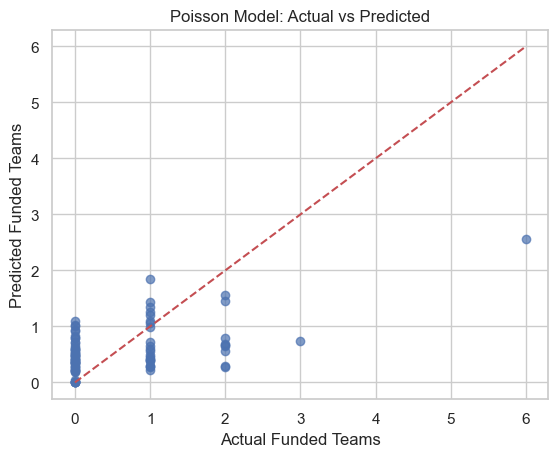

In [51]:
import matplotlib.pyplot as plt
df_model_funded["predicted"] = glm_final.predict()
plt.scatter(df_model_funded["num_funded_teams"], df_model_funded["predicted"], alpha=0.7)
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted Funded Teams")
plt.title("Poisson Model: Actual vs Predicted")
plt.plot([0, df_model_funded["num_funded_teams"].max()],
         [0, df_model_funded["num_funded_teams"].max()], 'r--')
plt.show()


## Compute MAE/RMSE/correlation

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predicted values from the final GLM
y_pred = glm_final.predict(X_final)

# Performance metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))  # manual square root
correlation = np.corrcoef(y, y_pred)[0, 1]

print("=== Model Performance Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Pearson Correlation: {correlation:.3f}")


=== Model Performance Metrics ===
Mean Absolute Error (MAE): 0.592
Root Mean Squared Error (RMSE): 0.791
Pearson Correlation: 0.555


## Export Actual vs Predicted to CSV

In [55]:
df_predicted = pd.DataFrame({
    "session": df_model_funded["session"],
    "actual_funded_teams": y,
    "predicted_funded_teams": y_pred
})
df_predicted.to_csv("poisson_predicted_vs_actual.csv", index=False)
print("Saved: poisson_predicted_vs_actual.csv")


Saved: poisson_predicted_vs_actual.csv


## Posterior Predictive Check (Poisson)

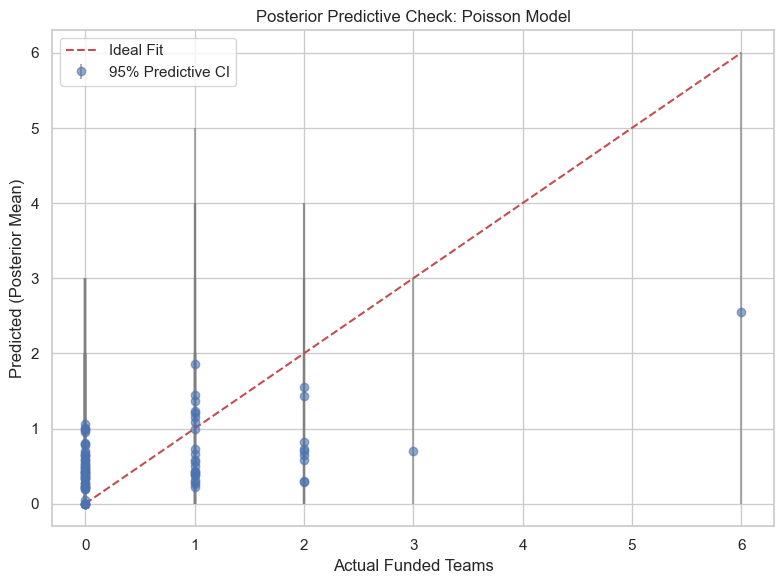

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate 1000 draws for each predicted lambda
ppc_samples = np.random.poisson(lam=y_pred, size=(1000, len(y_pred)))

# Plot: mean + 95% CI vs actual
ppc_mean = ppc_samples.mean(axis=0)
ppc_lower = np.percentile(ppc_samples, 2.5, axis=0)
ppc_upper = np.percentile(ppc_samples, 97.5, axis=0)

plt.figure(figsize=(8, 6))
plt.errorbar(
    y, ppc_mean, 
    yerr=[ppc_mean - ppc_lower, ppc_upper - ppc_mean],
    fmt='o', ecolor='gray', alpha=0.6, label='95% Predictive CI'
)
plt.plot([0, max(y)], [0, max(y)], 'r--', label='Ideal Fit')
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted (Posterior Mean)")
plt.title("Posterior Predictive Check: Poisson Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ranked Summary Table for num_funded_teams

In [57]:
# Summary table: most predictive features for funded teams
summary_df = glm_final.summary2().tables[1].copy()
summary_df["abs_z"] = summary_df["z"].abs()
top_predictors_funded = summary_df.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_funded.to_csv("top_predictors_funded.csv")
print("\n=== Top Predictive Features for num_funded_teams ===")
print(top_predictors_funded)



=== Top Predictive Features for num_funded_teams ===
                                        Coef.   Std.Err.         z     P>|z|
gesture_count_ratio                  5.734874   2.817997  2.035089  0.041842
idea_agree_decision_chain_duration  -0.333718   0.167431 -1.993165  0.046243
conflict_resolution_latency         -0.000704   0.000568 -1.238169  0.215654
num_overlaps                         0.038064   0.031806  1.196755  0.231402
num_provide_supporting_evidence     -0.035923   0.033477 -1.073053  0.283247
decision_lag                         0.000406   0.000384  1.057374  0.290341
num_explain_define_term              0.022377   0.024611  0.909251  0.363217
avg_distraction_per_utterance      -22.414651  25.819307 -0.868135  0.385320
burstiness_of_ideas                 -0.394467   0.459398 -0.858659  0.390528
num_offer_constructive_criticism     0.100590   0.118713  0.847333  0.396809


# Ranked Summary Table for num_teams

In [58]:
# Refit the final Poisson model for num_teams
from statsmodels.tools.tools import add_constant

y_teams = df_model_teams["num_teams"]
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()

# Summary table: most predictive features for total teams
summary_df_teams = glm_final_num_teams.summary2().tables[1].copy()
summary_df_teams["abs_z"] = summary_df_teams["z"].abs()

top_predictors_teams = summary_df_teams.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_teams.to_csv("top_predictors_teams.csv")

print("\n=== Top Predictive Features for num_teams ===")
print(top_predictors_teams)




=== Top Predictive Features for num_teams ===
                                       Coef.  Std.Err.         z     P>|z|
num_overlaps                        0.033336  0.020493  1.626697  0.103801
conflict_resolution_latency        -0.000603  0.000376 -1.604335  0.108640
num_offer_constructive_criticism    0.101510  0.072166  1.406629  0.159538
idea_agree_decision_chain_duration -0.011087  0.008273 -1.340198  0.180181
avg_nods_per_utterance              1.772161  1.479906  1.197482  0.231119
gesture_count_ratio                 1.992548  1.664014  1.197435  0.231137
decision_lag                        0.000254  0.000224  1.132117  0.257585
num_provide_supporting_evidence     0.021695  0.019430  1.116566  0.264180
avg_distraction_per_utterance       5.112881  4.893689  1.044791  0.296120
screenshare_count                   0.015034  0.016541  0.908889  0.363409


## Interpretation Highlights

- `gesture_count_ratio` is the strongest **positive predictor** of both `num_teams` and `num_funded_teams`, suggesting that more gesturing is associated with more teams being formed and funded.
- `idea_agree_decision_chain_duration` is a consistent **negative predictor** across both outcomes — faster agreement and decision-making may support better team outcomes.
- `conflict_resolution_latency` also shows a **negative trend** in both models, though it's not statistically significant. This may hint that faster conflict resolution is beneficial.